In [2]:
import numpy as np
import cv2
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from skimage.transform import rotate
from sklearn.cluster import KMeans

In [3]:
%matplotlib inline

In [4]:
def gauss1d(sigma, mean,x, order):
    x = np.array(x) - mean
    var = sigma**2
    g = (1/np.sqrt(2*np.pi*var))*(np.exp((-1*x*x)/(2*var)))
    
    if order == 0:
        return g
    elif order == 1:
        g = -g*((x)/(var))
        return g
    else:
        g = g*(((x*x) - var)/(var**2))
        return g

def gauss2d(n,sigma):
    size = int((n-1)/2)
    var = sigma**2
    m = np.asarray([[x**2 + y**2 for x in range(-size,size+1)] for y in range(-size,size+1)])
    output = (1/np.sqrt(2*np.pi*var))*np.exp(-m/(2*var))
    return output

def log2d(n,sigma):
    size = int((n-1)/2)
    var = sigma**2
    m = np.asarray([[x**2 + y**2 for x in range(-size,size+1)] for y in range(-size,size+1)])
    n = (1/np.sqrt(2*np.pi*var))*np.exp(-m/(2*var))
    output = n*(m - var)/(var**2)
    return output

def makefilter(scale, phasex, phasey, pts, sup):
    gx = gauss1d(3*scale, 0,pts[0,...], phasex)
    gy = gauss1d(scale, 0,pts[1,...], phasey)
    image = gx*gy
    image = np.reshape(image,(sup,sup))
    return image

def binary(img,bin_value):
    binary_img = img * 0
    for r in range(0,img.shape[0]):
        for c in range(0,img.shape[1]):
            if img[r, c]==bin_value:
                binary_img[r, c] = 1   
            else:
                binary_img[r, c] = 0
    return binary_img

   
def gradient(maps,numbins,mask_l,mask_r):
    gradient = np.zeros((maps.shape[0],maps.shape[1],12))
    for m in range(0,12):
        chi = np.zeros((maps.shape))
        for i in range(1,numbins):
            tmp = binary(maps,i)
            g = convolve2d(tmp, mask_l[m],'same')
            h = convolve2d(tmp, mask_r[m],'same')
            chi = chi + ((g-h)**2) / (g+h+0.0001)
        gradient[:,:,m] = chi
    return gradient

In [5]:
def LM_filter_bank():
    sup     = 49
    scalex  = np.sqrt(2) * np.array([1,2,3])
    norient = 6
    nrotinv = 12

    nbar  = len(scalex)*norient
    nedge = len(scalex)*norient
    nf    = nbar+nedge+nrotinv
    F     = np.zeros([sup,sup,nf])
    hsup  = (sup - 1)/2

    x = [np.arange(-hsup,hsup+1)]
    y = [np.arange(-hsup,hsup+1)]

    [x,y] = np.meshgrid(x,y)

    orgpts = [x.flatten(), y.flatten()]
    orgpts = np.array(orgpts)
    
    count = 0
    for scale in range(len(scalex)):
        for orient in range(norient):
#             rotpts = rotate(orgpts,orient)
            angle = (np.pi * orient)/norient
            c = np.cos(angle)
            s = np.sin(angle)
            rotpts = [[c,-s],[s,c]]
            rotpts = np.array(rotpts)
            rotpts = np.dot(rotpts,orgpts)
            F[:,:,count] = makefilter(scalex[scale],0, 1, rotpts, sup)
            F[:,:,count+nedge] = makefilter(scalex[scale],0, 2, rotpts, sup)
            count = count + 1
            
    count = nbar+nedge
    
    scales = np.sqrt(2) * np.array([1,2,3,4])
    
    for i in range(len(scales)):
        F[:,:,count]   = gauss2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, scales[i])
        count = count + 1
        
    for i in range(len(scales)):
        F[:,:,count] = log2d(sup, 3*scales[i])
        count = count + 1
        
    return F

(49, 49, 48)


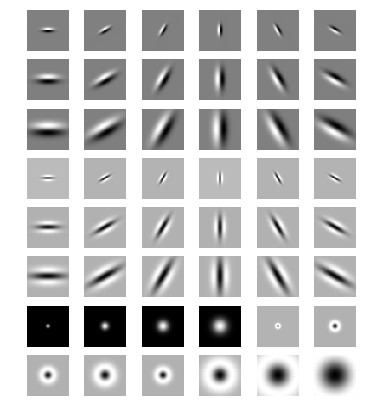

In [6]:
F = LM_filter_bank()
print F.shape
plt.figure(figsize=(6,8))
for i in range(0,48):
    plt.subplot(9,6,i+1)
    plt.axis('off')
    plt.imshow(F[:,:,i], cmap = 'gray')



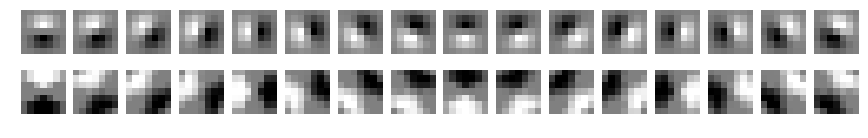

<Figure size 432x288 with 0 Axes>

In [23]:
def DOG_filter_bank():
    sobel = np.asarray([[1,2,1],
                        [0,0,0],
                        [-1,-2,-1]])

    ims = []
    s = 2
    o = 16
    sigma = [1,3]
    orientation = np.arange(0, 360,360/o)
    plt.figure(figsize=(15,2))
    for i in range(0,s):
        filter_ = convolve2d(gauss2d(5,sigma[i]), sobel)
        for j in range(0,o):
            filt = rotate(filter_,orientation[j])
            ims.append(filt)
            plt.subplot(s,o,o*(i)+j+1)
            plt.axis('off')
            plt.imshow(ims[o*(i)+j],cmap='gray')
            

    plt.show()
    plt.savefig("DoG_filter_bank")
    
    return ims

ims = DOG_filter_bank()

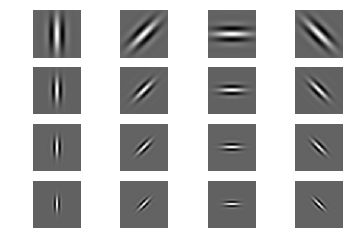

In [7]:
def genGabor(sz, omega, theta):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)

    gauss = omega**2 / (4*np.pi * np.pi**2) * np.exp(- omega**2 / (8*np.pi**2) * ( 4 * x1**2 + y1**2))

    sinusoid = np.cos(omega * x1) * np.exp(np.pi**2 / 2)

    gabor = gauss * sinusoid
    return gabor

theta = np.arange(0, np.pi, np.pi/4) # range of theta
omega = np.arange(0.2, 0.6, 0.1) # range of omega
params = [(t,o) for o in omega for t in theta]
FilterBank = []
gaborParams = []
for (theta, omega) in params:
    gaborParam = {'omega':omega, 'theta':theta, 'sz':(128, 128)}
    Gabor = genGabor((128,128),omega,theta)
    FilterBank.append(Gabor)
    gaborParams.append(gaborParam)

plt.figure()
n = len(FilterBank)
for i in range(n):
    plt.subplot(4,4,i+1)
    plt.axis('off'); plt.imshow(FilterBank[i],cmap='gray')
plt.show()




[  0  90 180 270]
(3, 4)


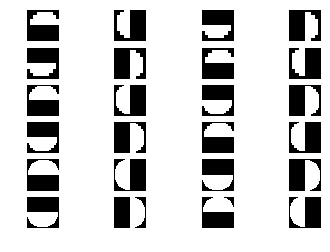

In [8]:
def half_disk(radius):
    hd = np.zeros((radius*2,radius*2))
    rs = radius**2;
    for i in range(0,radius):
        m = (i-radius)**2
        for j in range(0,2*radius):
            if m+(j-radius)**2 < rs:
                hd[i,j] =1
    return hd

orients = np.arange(0,360,360/4)
print(orients)
radii = np.asarray([5,10,15])
mask_l = []
mask_r = []
r = radii.size
o = orients.size
print(r,o)
for i in range(0,radii.size):
    hd = half_disk(radii[i])
    for m in range(0,orients.size):
        mask_1 = rotate(hd,orients[m])
        mask_l.append(mask_1)
        mask_2 = rotate(mask_1,180)
        mask_r.append(mask_2)
        
        plt.subplot(r*2,o,o*2*(i)+m+1)
        plt.axis('off')
        plt.imshow(mask_1,cmap='gray')
        plt.subplot(r*2,o,o*2*(i)+m+1+o)
        plt.axis('off')
        plt.imshow(mask_2,cmap='gray')
plt.show()


In [56]:
import glob
import os

os.chdir("../BSDS500/Images")
cwd = os.getcwd()
print(cwd)
cv_img = []
for img in sorted(glob.glob("*.jpg")):
    n= cv2.imread(img)
    cv_img.append(n)
os.chdir("../../Code")

/home/abhishek/CMSC733/akathpal_hw0/Phase1/BSDS500/Images


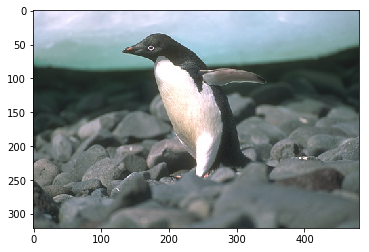

In [57]:
plt.imshow(cv2.cvtColor(cv_img[7],cv2.COLOR_BGR2RGB))

/home/abhishek/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


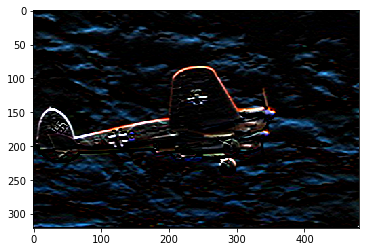

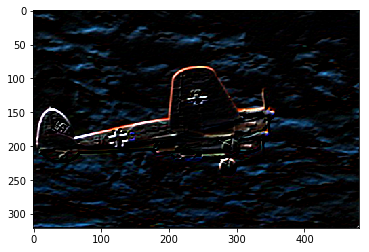

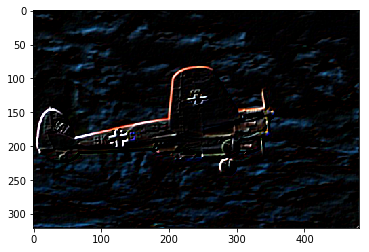

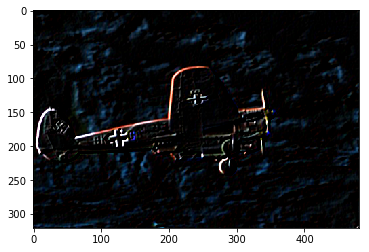

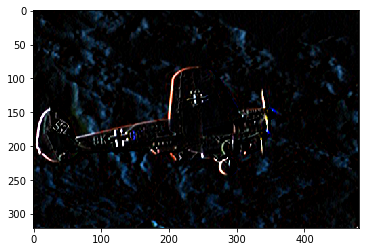

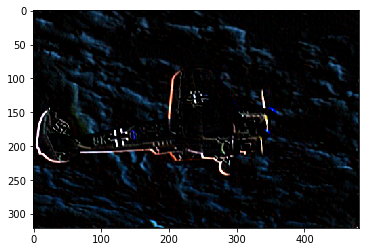

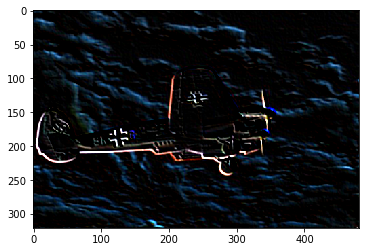

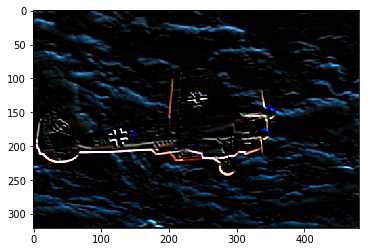

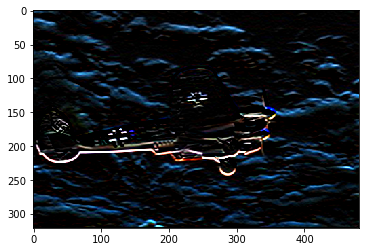

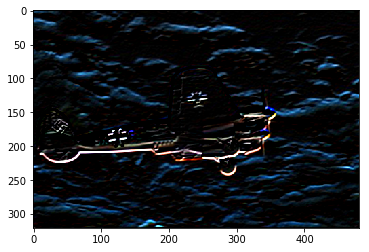

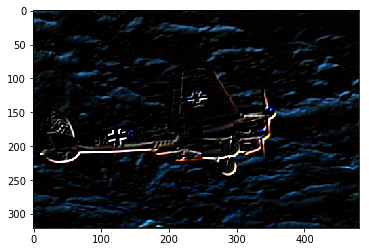

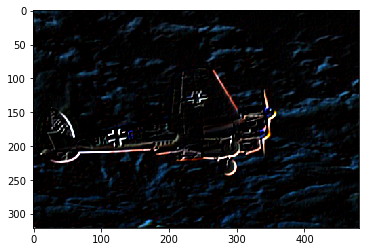

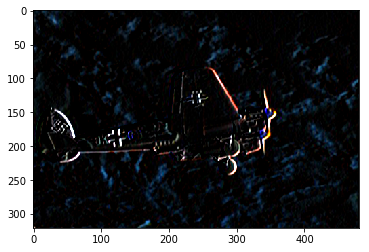

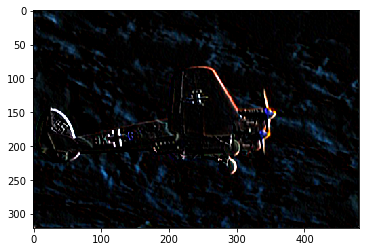

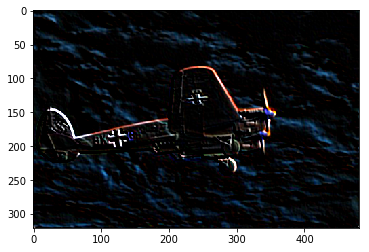

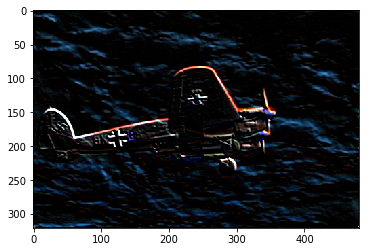

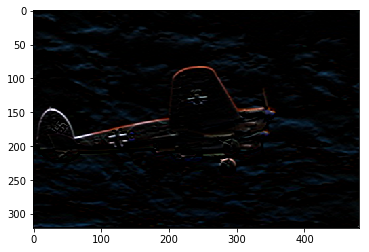

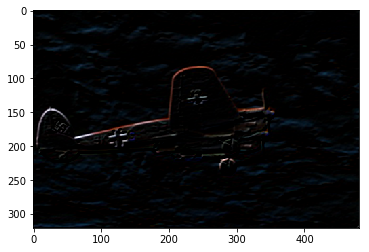

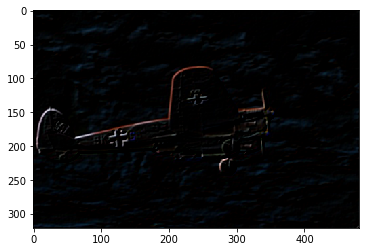

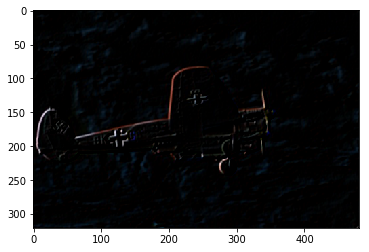

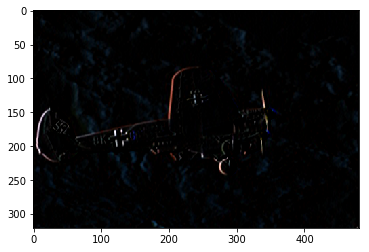

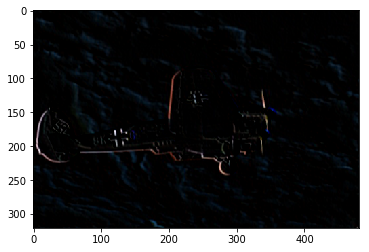

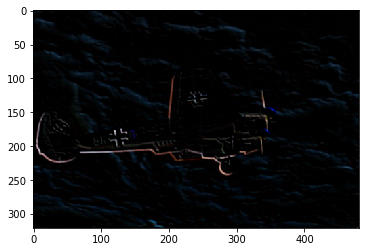

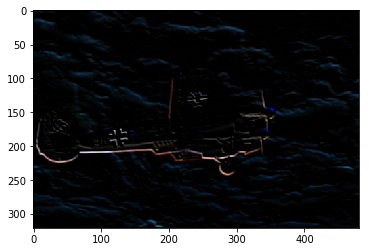

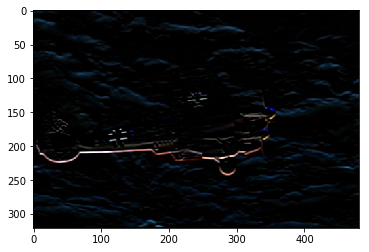

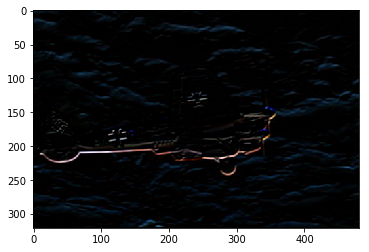

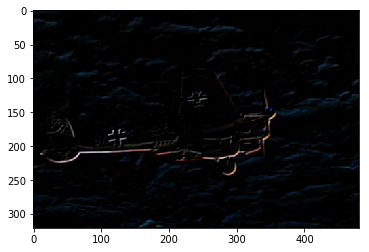

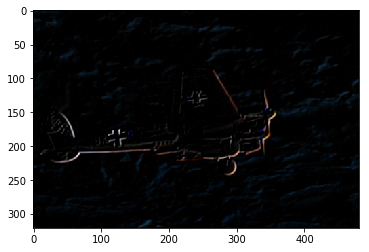

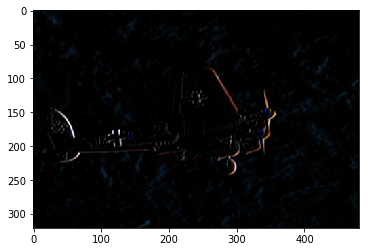

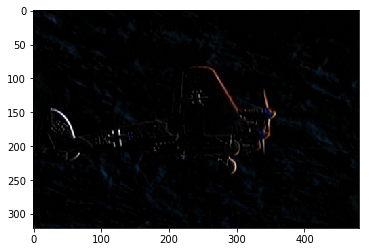

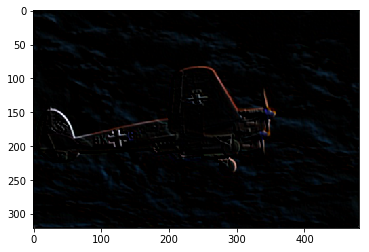

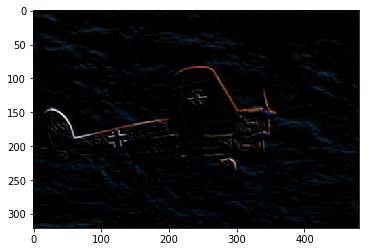

In [11]:
# n = cv2.cvtColor(cv_img[7],cv2.COLOR_BGR2GRAY)
n = cv_img[0]
dst=[]
for i in range(0,len(ims)):
    kernel = ims[i]
    m = cv2.filter2D(n, -1, kernel)
    dst.append(m)
    plt.figure()
    plt.imshow(m)

In [12]:
filter_bank = []
count = 0
for i in range(0,len(ims)):
    filter_bank.append(ims[i])
    count = count+1

# for i in range(0,48):
#     filter_bank.append(F[:,:,i])
#     count = count+1

# for i in range(len(sinFilterBank)):
#     filter_bank.append(sinFilterBank[i])
#     count = count+1
    
# for i in range(len(cosFilterBank)):
#     filter_bank.append(cosFilterBank[i])
#     count = count+1

print(count,len(filter_bank))

(32, 32)


In [13]:
tmap=cv2.cvtColor(cv_img[0],cv2.COLOR_BGR2GRAY)

print(tmap.size)
print(len(filter_bank))
data = np.zeros((tmap.size,len(filter_bank)))
for i in range(0,len(filter_bank)):
    temp_im = cv2.filter2D(tmap, -1, filter_bank[i])
    temp_im = temp_im.reshape((1,tmap.size))
    data[:,i] = temp_im

k_means = KMeans(n_clusters=64, n_init=4)
k_means.fit(data)
labels = k_means.labels_


154401
32


In [14]:
tmap = np.reshape(labels,(tmap.shape))

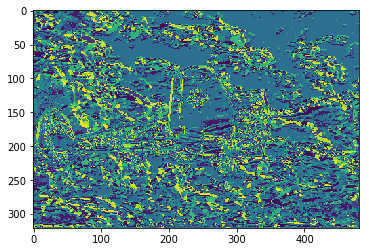

In [15]:
plt.imshow(tmap)

[ 3  3  3 ... 14  2 14]
(321, 481)
0
15
[[ 51.  51.  51. ...  17. 255.  17.]
 [ 51.  51.  51. ...  17. 255.  17.]
 [ 51.  51.  51. ...  17. 255. 255.]
 ...
 [238. 238. 238. ...  34.  34.  34.]
 [238. 238. 119. ...  34. 238. 238.]
 [119. 119. 119. ... 238.  34. 238.]]


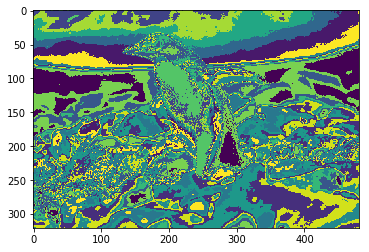

In [69]:
n = cv2.cvtColor(cv_img[7],cv2.COLOR_BGR2GRAY)
m = n.reshape((n.shape[0]*n.shape[1]),1)
k_means = KMeans(n_clusters=16, random_state=4)
k_means.fit(m)
labels = k_means.labels_
print(labels)
bmap = np.reshape(labels,(n.shape[0],n.shape[1]))
print(bmap.shape)
low = np.min(bmap)
print(low)
high = np.max(bmap)
print(high)
bmap_f = 255*(bmap-low)/np.float((high-low))
print(bmap_f)
plt.imshow(bmap_f)
# bg = gradient(bmap,16,mask_l,mask_r)


[[ 72.  34.  14. ...  31.  56.  20.]
 [ 89.  42.  17. ...  37.  68.  34.]
 [106.  49.  19. ...  44.  69.  42.]
 ...
 [106.  39.  14. ...   9.  23.  58.]
 [ 89.  33.  12. ...   8.  23.  52.]
 [ 72.  27.  12. ...   8.  21.  44.]]


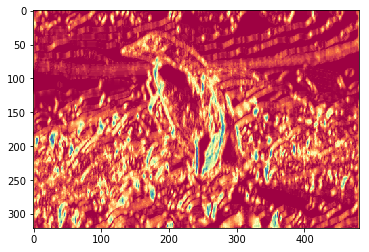

In [68]:
# low = np.min(bg[:,:,1])
# high = np.max(bg[:,:,1])
# l = 255*(bg[:,:,1]-low)/np.float((high-low))
# print(np.round_(l))
# plt.imshow(np.round_(l),cmap='Spectral')

[ 6  6  6 ... 12  7  2]
(321, 481)


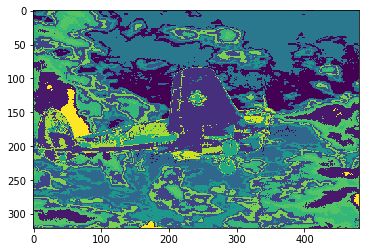

In [17]:
n = cv_img[0]
m = n.reshape((n.shape[0]*n.shape[1]),3)
k_means = KMeans(n_clusters=16, random_state=4)
k_means.fit(m)
labels = k_means.labels_
print(labels)
cmap = np.reshape(labels,(n.shape[0],n.shape[1]))
print(cmap.shape)
plt.imshow(cmap)

In [19]:
tg = gradient(tmap,64,mask_l,mask_r)
print(tg.shape)
bg = gradient(bmap,16,mask_l,mask_r)
print(bg.shape)
cg = gradient(cmap,16,mask_l,mask_r)
print(cg.shape)


(321, 481, 12)
(321, 481, 12)
(321, 481, 12)


/home/abhishek/CMSC733/akathpal_hw0/Phase1/BSDS500/CannyBaseline


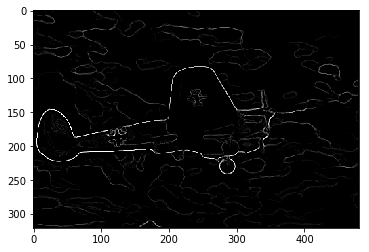

In [36]:
im = "1.png"
os.chdir("../BSDS500/CannyBaseline")
cwd = os.getcwd()
print(cwd)
c = cv2.imread(im)
plt.imshow(c)
os.chdir("../../Code")

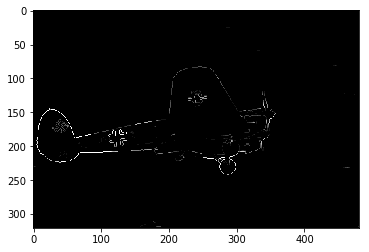

In [35]:
os.chdir("../BSDS500/SobelBaseline")
s = cv2.imread(im)
plt.imshow(s)
os.chdir("../../Code")

(321, 481)


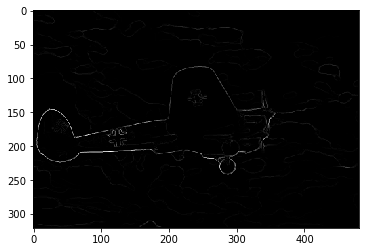

In [25]:
sm = cv2.cvtColor(s,cv2.COLOR_BGR2GRAY)
cm = cv2.cvtColor(c,cv2.COLOR_BGR2GRAY)

tgm = np.mean(tg, axis=2);
print(tgm.shape)
bgm = np.mean(bg, axis=2);
cgm = np.mean(cg, axis=2);
w = 0.5
pb = ((tgm+bgm+cgm)/3)*(w*cm+(1-w)*sm)
plt.imshow(pb,cmap='gray')
plt.imsave("1_pb.png",pb,cmap='gray')

In [34]:
# low=min(pb(:));
# high=max(pb(:));
# pb=(pb-low)/(high-low);
